## CS3570 Introduction to Multimedia Technology
### Homework 02 Due: 11:59pm, 4/11/2025

#### In the first part:
You are required to implement DCT compression with different quality factors with the given image file (cat.jpg), and calculate the SSIM score of between the original image and compressed images.

Here's the step:
1. Convert the image from RGB to YCbCr following with chrominance subsampling 4:2:0.
2. Divide the Y, Cb, Cr channels into blocks of 8 x 8 pixels.
3. Shift values by -128 and transform the each 8x8 blocks from spatial domain to the DCT domain.
4. Apply quantization with the provided quantization tables and quality factor.
5. Reconstruct the image by taking inverse discrete cosine transform (IDCT) and shift values by +128.
6. Reassemble the Y, Cb, Cr channels from 8x8 blocks.
7. Upsample Cb, Cr and convert YCbCr back to RGB.
8. Compute the PSNR score with reconstructed images and the original image.

#### In the second part:
You need to design and apply different FIR filters into separate three audio signals from the given audio file (HW2_Mix.wav). Next, you are asked to reduce the sampling rate of filtered signals. Finally, since the output audio signals are too simple, you should apply one-fold echo and multiple-fold echo to produce more complex music.

Here's the step:
1. Transform the input signal into frequency domain and plot the spectrum (magnitude in spectrum should be normalized to [0, 1]).
2. Implement 3 different FIR filters to separate the three audio signals with Blackman window function (You have to pick the appropriate filter size, cut-off frequency, and window size).
3. Implement 1D convolution on the input signal with your filters (zero padding).
4. Reduce the sampling rates of the three separated songs to 2000Hz.
5. Apply one-fold echo and multiple-fold echo on the signal that pass through the **low-pass filter**. (Please use the audio files before reducing sampling rates)

### Reminder:
* **The imported libraries are sufficient for this homework, you are not permitted to import other Python packages.**
* **Your code must display and output your results to enable us to verify its correctness.**
* **Please follow the instructions in the Jupyter Notebook and complete the parts marked as `"TODO."`**
* **Please compress your Jupyter Notebook file, image results from Q1 and audio results from Q2 in a zip file named HW2_xxxxxxxxx_ooo.zip, where xxxxxxxxx is your student ID and ooo is your name.**
* **Homework should be submitted before the announced due time. Scores of late homework will be reduced by 20% per day.**
* **If you encounter any problems or have questions, please post them on eeclass.**

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Part 1: DCT compression (40%)

### Import the necessary libraries

In [58]:
# !pip install opencv-python numpy matplotlib scipy

import numpy as np
from cv2 import imread, imwrite
import matplotlib.pyplot as plt

### Define the quantization tables

In [ ]:
# Quantization table for Y
QT_L = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 36, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Quantization table for Cb, Cr
QT_Chroma = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

### 1. Implement RGB to YCbCr and chrominance subsampling (4:2:0) (5%)

In [ ]:
def RGB2YCbCr(img):
    '''
    Input:
        img: input image (RGB)
    Output:
        Y: Y channel
        Cb: Cb channel
        Cr: Cr channel
    '''
    H, W, _ = img.shape
    img_ycbcr = np.zeros(img.shape)
    Y = np.zeros((H, W))
    Cb = np.zeros((H//2, W//2))
    Cr = np.zeros((H//2, W//2))

    # matrices for calculating RGB to YCbCr
    M = np.array([[0.257, 0.564, 0.098],
                  [-0.148, -0.291, 0.439],
                  [0.439, -0.368, -0.071]])
    C = np.array([16, 128, 128])

    # [TODO]: Convert RGB to YCbCr with chrominance subsampling (4:2:0)
    img_float = img.astype(np.float32)
    img_ycbcr_full = np.dot(img_float, M.T) + C
    Y_full = img_ycbcr_full[..., 0]
    Cb_full = img_ycbcr_full[..., 1]
    Cr_full = img_ycbcr_full[..., 2]

    Y = Y_full
    Cb = Cb_full[::2, ::2]
    Cr = Cr_full[::2, ::2]

    return Y, Cb, Cr

### 2. Implement YCbCr to RGB (5%)

In [ ]:
def YCbCr2RGB(Y, Cb, Cr):
    '''
    Input:
        Y: Y channel
        Cb: Cb channel
        Cr: Cr channel
    Output:
        img: output image (RGB)
    '''
    H, W = Y.shape
    # [TODO]: Upsample Cb and Cr
    Cb_upsample = np.repeat(np.repeat(Cb, 2, axis=0), 2, axis=1)
    Cr_upsample = np.repeat(np.repeat(Cr, 2, axis=0), 2, axis=1)

    img_YCbCr = np.stack((Y, Cb_upsample, Cr_upsample), axis=-1)
    img = np.zeros((H, W, 3))

    # matrices for converting YCbCr to RGB
    M = np.array([[1.164, 0, 1.596],
                  [1.164, -0.392, -0.813],
                  [1.164, 2.017, 0]])
    C = np.array([16, 128, 128])

    # [TODO]: Convert YCbCr back to RGB
    img = (img_YCbCr - C) @ M.T
    img = np.clip(img, 0, 255).astype(np.uint8)

    return img

### 3. Implement Discrete Cosine Transform (DCT) (5%)

In [ ]:
def DCT(f):
    '''
    Input:
        f: image block
    Output:
        F: DCT transformed image block
    '''
    # [TODO]: Implement discrete cosine transform
    N = f.shape[0]  # Assuming square block
    F = np.zeros((N, N), dtype=np.float32)

    # Pre-calculate the scaling factors for efficiency.
    def alpha(k):
        return np.sqrt(1/N) if k == 0 else np.sqrt(2/N)

    # Calculate the DCT coefficients.
    for u in range(N):
        for v in range(N):
            sum_val = 0.0
            for x in range(N):
                for y in range(N):
                    sum_val += f[x, y] * np.cos((2*x+1)*u*np.pi/(2*N)) * np.cos((2*y+1)*v*np.pi/(2*N))
            F[u, v] = alpha(u) * alpha(v) * sum_val
    return F

### 4. Implement Inverse Discrete Cosine Transform (IDCT) (5%)

In [ ]:
def IDCT(F):
    '''
    Input:
        F: DCT transformed image block
    Output:
        f: image block
    '''
    # [TODO]: Implement inverse discrete cosine transform
    N = F.shape[0]
    f = np.zeros((N, N), dtype=np.float32)

    def alpha(k):
        return np.sqrt(1/N) if k == 0 else np.sqrt(2/N)

    for x in range(N):
        for y in range(N):
            sum_val = 0.0
            for u in range(N):
                for v in range(N):
                    sum_val += alpha(u) * alpha(v) * F[u, v] * \
                               np.cos((2*x+1)*u*np.pi/(2*N)) * np.cos((2*y+1)*v*np.pi/(2*N))
            f[x, y] = sum_val
    return f

### 5. Implement quantization with quality factor (5%)

In [ ]:
def quantize(img, Qf, chroma=True):
    '''
    Input:
        img: image block
        Qf: quality factor
    Output:
        img: quantized image block
    '''
    # [TODO]: Implement quantization
    S = Qf
    if chroma:
        T_s = QT_Chroma
    else:
        T_s = QT_L

    img_quantized = np.round(img / (T_s * S)) * (T_s * S)

    return img_quantized

### 6. DCT compression process (10%)

In [ ]:
def dct_compression(img, Qf):
    '''
    Input:
        img: input image
        Qf: quality factor
    Output:
        compressed: compressed image
    '''
    height, weight, _ = img.shape
    block_size = 8

    Y, Cb, Cr = RGB2YCbCr(img)
    Y_compressed = np.zeros(Y.shape)
    Cb_compressed = np.zeros(Cb.shape)
    Cr_compressed = np.zeros(Cr.shape)

    # [TODO]: Implement the DCT compression process
    # Y
    for i in range(0, height, block_size):
        for j in range(0, weight, block_size):
            block = Y[i:i+block_size, j:j+block_size]
            # 假設區塊大小均為 8x8 (否則需要 padding)
            block_shifted = block - 128
            dct_block = DCT(block_shifted)
            quant_block = quantize(dct_block, Qf, chroma=False)
            idct_block = IDCT(quant_block)
            Y_compressed[i:i+block_size, j:j+block_size] = idct_block + 128

    # Cb
    Hc, Wc = Cb.shape
    for i in range(0, Hc, block_size):
        for j in range(0, Wc, block_size):
            block = Cb[i:i+block_size, j:j+block_size]
            block_shifted = block - 128
            dct_block = DCT(block_shifted)
            quant_block = quantize(dct_block, Qf, chroma=True)
            idct_block = IDCT(quant_block)
            Cb_compressed[i:i+block_size, j:j+block_size] = idct_block + 128

    # Cr
    Hc, Wc = Cr.shape
    for i in range(0, Hc, block_size):
        for j in range(0, Wc, block_size):
            block = Cr[i:i+block_size, j:j+block_size]
            block_shifted = block - 128
            dct_block = DCT(block_shifted)
            quant_block = quantize(dct_block, Qf, chroma=True)
            idct_block = IDCT(quant_block)
            Cr_compressed[i:i+block_size, j:j+block_size] = idct_block + 128

    img_compressed = YCbCr2RGB(Y_compressed, Cb_compressed, Cr_compressed)

    return np.clip(img_compressed, 0, 255).astype(np.uint8)

### 7. Implement Peak Signal-to-Noise Ratio (PSNR) (5%)

In [ ]:
def PSNR(original, compressed):
    '''
    Input:
        original: original image
        compressed: compressed image
    Output:
        psnr: PSNR value
    '''
    # [TODO]: Calculate PSNR from the original image and the compressed image
    mse = np.mean((original.astype(np.float32) - compressed.astype(np.float32)) ** 2)
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 10 * np.log10((255 ** 2) / mse)
    return psnr

### Experiment with different quality factor

In [ ]:
image = imread('/content/drive/MyDrive/多媒體/Homework_02/Barbara.jpg')

Qf = 80
compressed_img = dct_compression(image, Qf)
print(f"PSNR (Qf={Qf}): {PSNR(image, compressed_img)}")
imwrite(f'Barbara_quality-{Qf}.jpg', compressed_img)

Qf = 30
compressed_img = dct_compression(image, Qf)
print(f"PSNR (Qf={Qf}): {PSNR(image, compressed_img)}")
imwrite(f'Barbara_quality-{Qf}.jpg', compressed_img)

Qf = 5
compressed_img = dct_compression(image, Qf)
print(f"PSNR (Qf={Qf}): {PSNR(image, compressed_img)}")
imwrite(f'Barbara_quality-{Qf}.jpg', compressed_img)

PSNR (Qf=80): 13.71295166015625
PSNR (Qf=30): 17.494718551635742
PSNR (Qf=5): 24.498798370361328


True

## Part 2: FIR Filter (40%)

In [59]:
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

### 1. Plot the frequency spectrum (5%)

In [76]:
def plot_spectrum(data, title, fs, xbond, ybond):
    '''
    Input:
        data: input signal
        title: title of the plot
        fs: sampling frequency
        xbond: x-axis range
        ybond: y-axis range
    '''
    # TODO: FFT & Plot the magnitude spectrum of the input signal
    N = len(data)
    fft_result = np.fft.fft(data)
    magnitude = np.abs(fft_result) / N
    freq = np.fft.fftfreq(N, 1/fs)[:N//2]
    magnitude = magnitude[:N//2] * 2
    magnitude[0] /= 2

    result = np.column_stack((freq, magnitude))

    plt.figure()
    plt.xlim(xbond[0], xbond[1])
    plt.ylim(ybond[0], ybond[1])
    plt.plot(result[:, 0], result[:, 1])
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(title)

def plot_filter_response(h, sample_rate):
    H = fft(h, 2048)
    H = np.abs(H[:1024])
    freqs = np.linspace(0, sample_rate/2, 1024)
    plt.plot(freqs, 20 * np.log10(H + 1e-10))
    plt.title("Filter Frequency Response")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.grid()
    plt.show()

### 2. Implement three different filters - Lowpass, Highpass, Bandpass (10%)

In [85]:
def filter_generator(sample_rate, cutoff, filter_type, window_type, N):
    '''
    Input:
        sample_rate: sampling frequency
        cutoff: cutoff frequency
        filter_type: type of filter (Lowpass, Highpass, Bandpass)
        window_type: type of window function (Blackmann)
        N: filter length (number of points in a filter), also the window length
    Output:
        filter: low-pass, high-pass, or band-pass filter
    '''
    # Normalize cutoff frequency
    if filter_type == 'Lowpass' or filter_type == 'Highpass':
        cutoff = cutoff / sample_rate
    elif filter_type == 'Bandpass':
        cutoff = [cutoff[0] / sample_rate, cutoff[1] / sample_rate]
    else:
        raise ValueError('Invalid filter type')

    mid = N // 2
    n = np.arange(-mid, mid+1)

    # implement the ideal filter
    if filter_type == 'Lowpass':
        # [TODO]: Implement the Low-pass filter
        h = 2 * cutoff * np.sinc(2 * cutoff * n)
    elif filter_type == 'Highpass':
        # [TODO]: Implement the High-pass filter
        h = np.sinc(n) - 2 * cutoff * np.sinc(2 * cutoff * n)
    elif filter_type == 'Bandpass':
        # [TODO]: Implement the Band-pass filter
        filter_low = 2 * cutoff[0] * np.sinc(2 * cutoff[0] * n)
        filter_high = 2 * cutoff[1] * np.sinc(2 * cutoff[1] * n)
        h = filter_high - filter_low

    n = np.arange(0, N)
    # implement the window function
    if window_type == "Blackmann":
        # [TODO]: Implement Blackmann window function
        window = 0.42 - 0.5 * np.cos(2 * np.pi * np.arange(N)/(N-1)) + 0.08 * np.cos(4 * np.pi * np.arange(N)/(N-1))
        h *= window

    return h

In [62]:
def plot_filter(filter, title):

    plt.figure()
    plt.plot(filter)
    plt.title(title)
    plt.xlabel('samples')
    plt.ylabel('amplitude')
    plt.show()

### 3. Implement convolution function (10%)

In [82]:
def convolve(signal , filter , N):
    '''
    Input:
        signal: input signal
        filter: filter
        N: filter length
    Output:
        out: output signal
    '''
    len_signal = len(signal)
    out = np.zeros(len(signal))

    # [TODO]: Implement the 1D convolution operation
    mid = N // 2
    for n in range(len_signal):
        s = 0
        for k in range(N):
            index = n - (k - mid)
            if 0 <= index < len_signal:
                s += signal[index] * filter[k]
        out[n] = s

    return out

### 4. Reduce sample rate (5%)

In [64]:
def down_sampling(signal, fs, new_fs):
    '''
    Input:
        signal: input signal
        fs: sampling frequency
        new_fs: new sampling frequency
    Output:
        output_signal: down-sampled signal
    '''
    # [TODO]: Implement the down-sampling operation
    factor = int(fs / new_fs)
    output_signal = signal[::factor]

    return output_signal

### 5. Implement one-fold / multiple-fold echo (10%)

In [65]:
def echo(signal_low, delay, alpha, fs):
    '''
    Input:
        signal_low: input signal (time-domain)
        delay: delay time
        alpha: attenuation factor
        fs: sampling frequency
    Output:
        output_echo_one: output signal with one-fold echo
        output_echo_multiple: output signal with multiple-fold echo
    '''

    D = int(delay * fs)
    input_len = len(signal_low)
    output_echo_one = np.zeros(input_len + D)

    #[TODO]: One-fold echo
    output_echo_one = np.zeros(input_len + D)
    output_echo_one[:input_len] = signal_low
    output_echo_one[D:D+input_len] += alpha * signal_low

    #[TODO]: Multiple-fold echo
    output_echo_multiple = signal_low.copy()
    current = output_echo_multiple
    for _ in range(10):
        echoed = np.pad(alpha * current, (D, 0))[:len(current)]
        output_echo_multiple += echoed
        current = echoed
        alpha *= alpha


    output_echo_one = output_echo_one.astype(np.float32)
    output_echo_multiple = output_echo_multiple.astype(np.float32)

    return  output_echo_one, output_echo_multiple

### Note: There should be 10 images displayed below the cell.

<ipython-input-86-e5d0cf76a454>:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read('/content/drive/MyDrive/多媒體/Homework_02/HW2_Mix.wav')


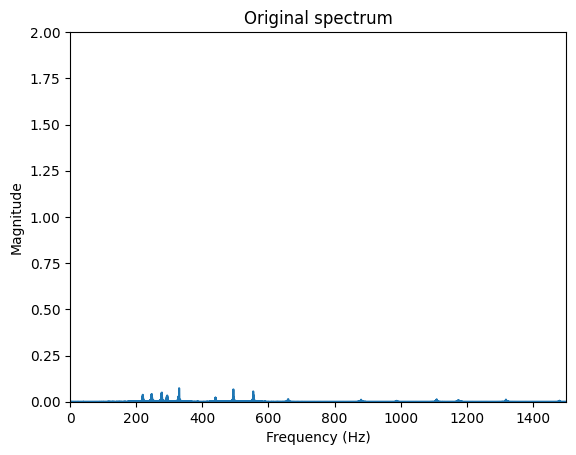

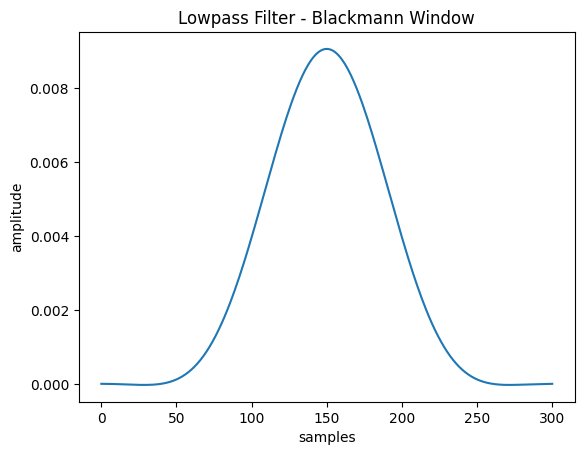

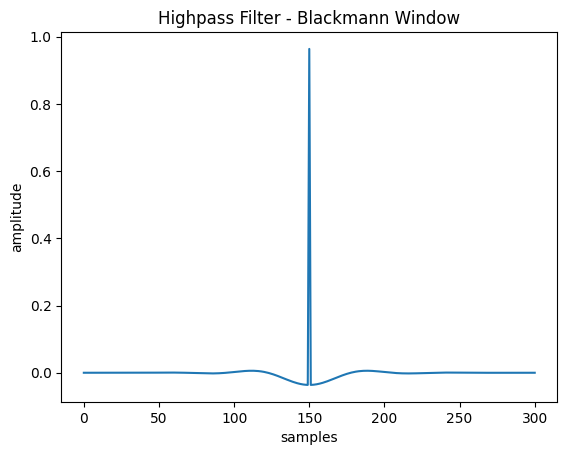

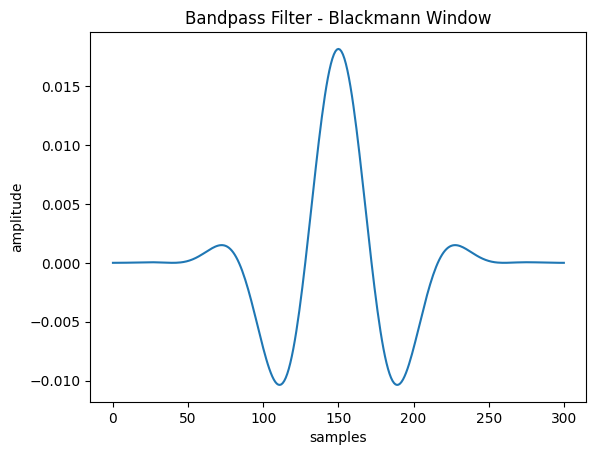

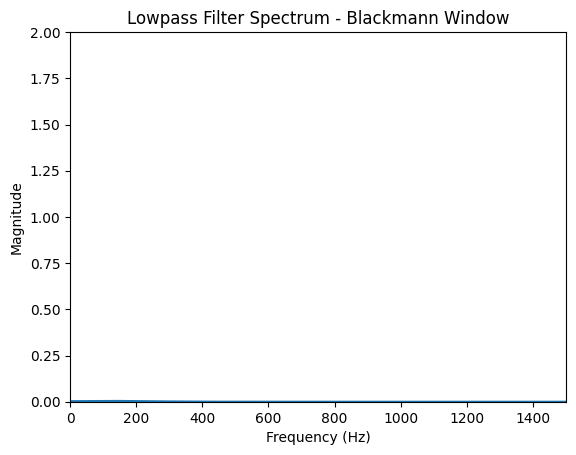

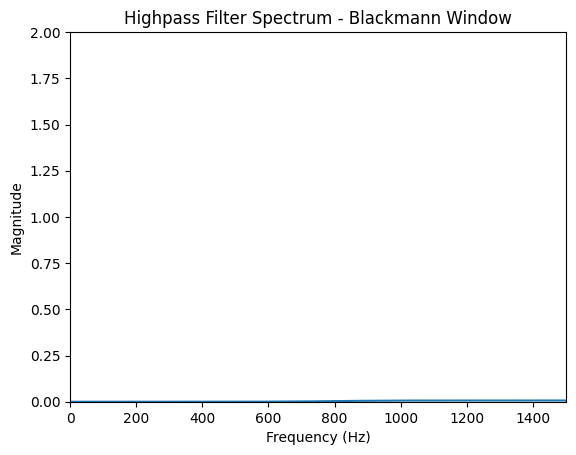

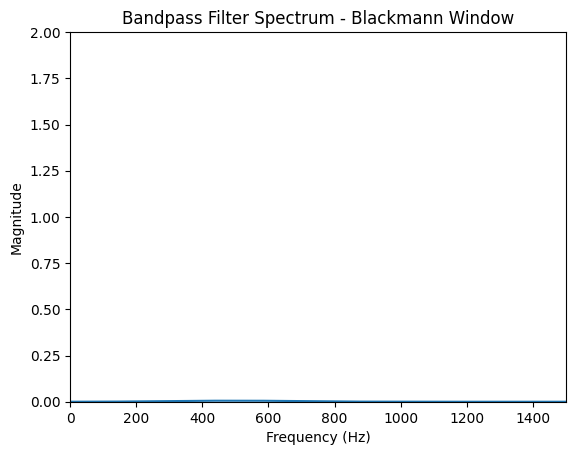

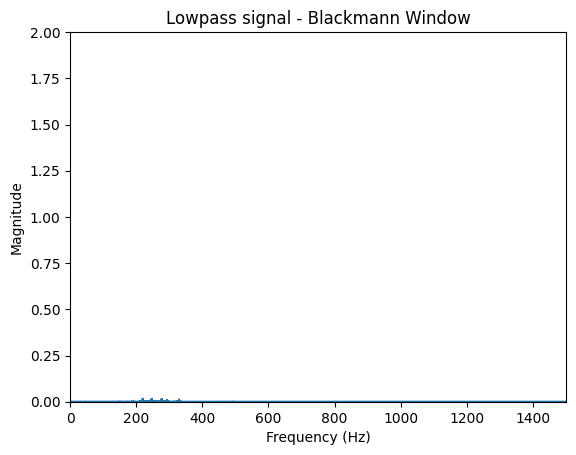

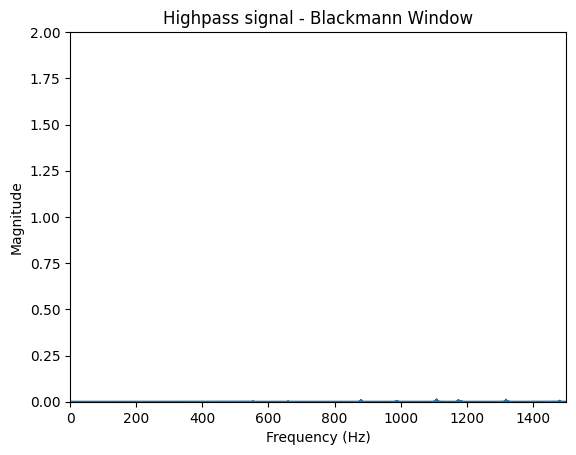

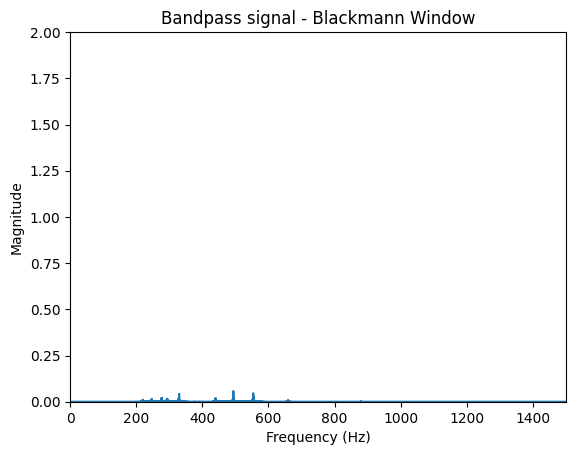

In [86]:
# Read the wav file
fs, data = wavfile.read('/content/drive/MyDrive/多媒體/Homework_02/HW2_Mix.wav')

# Plot the magnitude spectrum of the input signal
plot_spectrum(data, "Original spectrum", fs, [0, 1500], [0, 2])

# [TODO]: determine the cutoff frequency and window size
fc_low = 200
fc_high = 800
fc_band = [300, 700]
filter_size = 301

# Generate filter with Blackmann window - Lowpass, Highpass, Bandpass
lowpass_blackmann_filter = filter_generator(fs, fc_low, 'Lowpass', 'Blackmann', filter_size)
highpass_blackmann_filter = filter_generator(fs, fc_high, 'Highpass', 'Blackmann', filter_size)
bandpass_blackmann_filter = filter_generator(fs, fc_band, 'Bandpass', 'Blackmann', filter_size)

# Plot filter shape
plot_filter(lowpass_blackmann_filter, "Lowpass Filter - Blackmann Window")
plot_filter(highpass_blackmann_filter, "Highpass Filter - Blackmann Window")
plot_filter(bandpass_blackmann_filter, "Bandpass Filter - Blackmann Window")

# Plot the magnitude spectrum of different filters
plot_spectrum(lowpass_blackmann_filter, "Lowpass Filter Spectrum - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(highpass_blackmann_filter, "Highpass Filter Spectrum - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(bandpass_blackmann_filter, "Bandpass Filter Spectrum - Blackmann Window", fs, [0, 1500], [0, 2])

# Convolve the input signal with different filters
signal_low = convolve(data, lowpass_blackmann_filter, filter_size)
signal_high = convolve(data, highpass_blackmann_filter, filter_size)
signal_band = convolve(data, bandpass_blackmann_filter, filter_size)
plot_spectrum(signal_low, "Lowpass signal - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(signal_high, "Highpass signal - Blackmann Window", fs, [0, 1500], [0, 2])
plot_spectrum(signal_band, "Bandpass signal - Blackmann Window", fs, [0, 1500], [0, 2])

# save audio
wavfile.write(f"Low_pass_{fc_low}.wav", fs, signal_low)
wavfile.write(f"High_pass_{fc_high}.wav", fs, signal_high)
wavfile.write(f"Band_pass_{fc_band[0]}_{fc_band[1]}.wav", fs, signal_band)

# Reduce sample rate
new_fs = 2000
signal_low_ds = down_sampling(signal_low, fs, new_fs)
signal_high_ds = down_sampling(signal_high, fs, new_fs)
signal_band_ds = down_sampling(signal_band, fs, new_fs)

# You can also try setting 'new_fs' as 'fs' to see what happens.
wavfile.write(f"Low_pass_{fc_low}_2khz.wav", new_fs, signal_low_ds)
wavfile.write(f"High_pass_{fc_high}_2khz.wav", new_fs, signal_high_ds)
wavfile.write(f"Band_pass_{fc_band[0]}_{fc_band[1]}_2khz.wav", new_fs, signal_band_ds)

# Generate echo
echo_one , echo_multiple = echo(signal_low, 1, 0.5, fs)
wavfile.write('Echo_one.wav', fs, echo_one)
wavfile.write("Echo_multiple.wav", fs, echo_multiple)

## Report (20%)

Your report should cover the following aspects:
* DCT compression
    * Describe how you implemented the discrete cosine transform. (4%)
      * 將影像分成小區塊（例如 8×8 像素），以便分離不同頻率分量。
      * 針對每個區塊計算 2D DCT，將空間域的像素值轉換為頻域係數。計算中利用公式並考量正規化係數（如 u 或 v 為 0 時需乘上 1/√2）。
      * 利用巢狀迴圈實現轉換，藉由向量化操作來提升效能。
    * Why should we convert image from RGB to YCbCr before compressing? (3%)
      * YCbCr 的 Y 通道代表亮度，而 Cb 和 Cr 為色度。由於人眼對亮度較敏感，色度可以做更高程度的壓縮。
      * 將資料分離後，可以針對不同通道使用不同的量化矩陣，達到更好的壓縮效果且不明顯影響視覺品質。
    * Explain how can the quality factor affects the compression result. (3%)
      * 影響量化矩陣的刻度，品質越高，量化步長變小，保留更多細節；反之則更激進地量化，壓縮比提高，但可能引入壓縮痕跡
* FIR Filter
    * Describe how you implemented the filter and convolutions to separate tha mixed song. And how did you determine the filter size and cut-off frequency. (4%)
      * 依據欲分離聲音成分的頻率特性，利用視窗法等技巧設計 FIR 濾波器，計算相應的濾波器係數。
      * 濾波過程使用卷積操作，將濾波器係數與混合音訊作運算，藉此保留或抑制特定頻率成份。
      * 利用音訊軟體和程式碼測試找到適當的參數
    * Compare the spectrum and shape of the filters. (3%)
      * FIR 濾波器的脈衝響應通常呈對稱分佈，代表線性相位，當使用 Hamming 或 Blackman 視窗時，曲線會平滑下降
    * Compare the difference between the signals before and after reducing the sampling rates. (3%)
      * 降低取樣率後，數據點變少，導致時域信號較為平滑，部分細節和瞬態特徵可能會變得不明顯。
      * 降低取樣率前需先使用抗混疊濾波器過濾掉高於新 Nyquist 頻率的成分，因此經過降低取樣率後，頻譜中的高頻成分會被刪除，整體頻譜範圍縮小且更集中於低頻部分。
